# Build a Multi-Agent Research Pipeline with LangGraph

![Multi-Agent Research Pipeline](images/multi-agent-research-pipeline.png)


In [1]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

## Build a team of Analysts

In [3]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    organization: str = Field(
        description="Where the analyst works or is connected to.",
    )
    full_name: str = Field(
        description="The analyst's full name."
    )
    job_title: str = Field(
        description="What the analyst does in this project or topic.",
    )
    about: str = Field(
        description="What the analyst cares about, what they focus on, or why they're involved.",
    )
    @property
    def profile(self) -> str:  # profile is defined as a property inside the Analyst class.
        return f"""
Name: {self.full_name}
Title: {self.job_title}
Organization: {self.organization}
About: {self.about}
        """

class TeamOfAnalysts(BaseModel):
    analysts: List[Analyst] = Field(
        description="A list of people giving their input on the topic.",
    )

class AnalystSetup(TypedDict):
    topic: str                  # What this team is researching or discussing
    number_of_analysts: int     # How many analysts we want to include
    editor_feedback: str         # Notes or feedback from a human reviewer
    analysts: List[Analyst]     # The current list of analysts

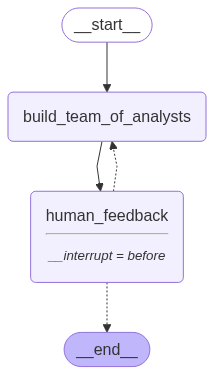

In [4]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


def build_team_of_analysts(state: AnalystSetup):
    system_message = f"""
    Your task is to create a team of AI analysts. Please follow these steps:
	
    1.	Read the research topic:
    {state['topic']}

	2.	Look at the optional notes or feedback from a human editor. It may help shape the analysts:
    {state.get('editor_feedback', '')}

	3.	Find the most interesting ideas or issues based on the topic and feedback.
	
    4.	Choose the top {state['number_of_analysts']} ideas.
	
    5.	Create one analyst for each idea — each analyst should focus on just one theme.
    """
    
    structured_llm = llm.with_structured_output(TeamOfAnalysts)
    analysts = structured_llm.invoke([SystemMessage(content=system_message), HumanMessage(content="Create a team of analysts for this topic.")])
    
    return {"analysts": analysts.analysts}

def human_feedback(state: AnalystSetup):
    pass

def should_continue(state: AnalystSetup):
    human_feedback = state.get('editor_feedback', None)
    if human_feedback:
        return "build_team_of_analysts"
    return END

# Add nodes and edges 
builder = StateGraph(AnalystSetup)
builder.add_node("build_team_of_analysts", build_team_of_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "build_team_of_analysts")
builder.add_edge("build_team_of_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["build_team_of_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [5]:
thread = {"configurable": {"thread_id": 3}}

setup = graph.invoke({
    "topic": "What Model Context Protocol is and why it makes AI smarter", 
    "number_of_analysts": 3}, 
    thread)

for analyst in setup['analysts']:
    print(analyst.profile)


Name: Dr. Emily Chen
Title: Senior AI Researcher
Organization: AI Research Institute
About: Dr. Chen focuses on the implications of context in AI systems, studying how contextual understanding enhances the performance and adaptability of AI models.
        

Name: Mr. David Martinez
Title: Machine Learning Engineer
Organization: Tech Innovations Lab
About: Mr. Martinez specializes in the development of machine learning algorithms that incorporate contextual data, believing that the right context can significantly improve AI decision-making processes.
        

Name: Ms. Sarah Patel
Title: Data Analyst
Organization: Data Insights Corp
About: Ms. Patel is dedicated to exploring how context-aware models can analyze vast datasets more intelligently and efficiently, ultimately leading to smarter AI solutions.
        


In [6]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [7]:
graph.update_state(thread, {
    "editor_feedback": "I think it would be helpful to add an analyst who focuses on how developers actually use MCP in real-world coding."}, 
    as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07aeea-41a6-61a9-8002-576204cde9d9'}}

In [8]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(analyst.profile)


Name: Dr. Emily Chen
Title: Senior AI Researcher
Organization: AI Research Institute
About: Dr. Chen focuses on the implications of context in AI systems, studying how contextual understanding enhances the performance and adaptability of AI models.
        

Name: Mr. David Martinez
Title: Machine Learning Engineer
Organization: Tech Innovations Lab
About: Mr. Martinez specializes in the development of machine learning algorithms that incorporate contextual data, believing that the right context can significantly improve AI decision-making processes.
        

Name: Ms. Sarah Patel
Title: Data Analyst
Organization: Data Insights Corp
About: Ms. Patel is dedicated to exploring how context-aware models can analyze vast datasets more intelligently and efficiently, ultimately leading to smarter AI solutions.
        

Name: Dr. Emily Carter
Title: MCP Research Specialist
Organization: Tech Innovators Inc.
About: Dr. Carter focuses on the theoretical implications of the Model Context Proto

In [9]:
graph.update_state(thread, {"editor_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07aeea-f4f6-6a3d-8004-c94715efa1f1'}}

In [10]:
graph.stream(None, thread, stream_mode="values")
final_state = graph.get_state(thread)
print(final_state.next)

analysts = final_state.values.get('analysts')
for analyst in analysts:
    print(analyst.profile)

()

Name: Dr. Emily Carter
Title: MCP Research Specialist
Organization: Tech Innovators Inc.
About: Dr. Carter focuses on the theoretical implications of the Model Context Protocol, exploring how it enhances the intelligence and adaptability of AI systems by providing structured context for data interpretation.
        

Name: Jason Lim
Title: Software Engineer and MCP Implementation Expert
Organization: CodeHub Solutions
About: Jason works closely with developers to implement the Model Context Protocol in real-world coding environments, emphasizing practical applications, coding patterns, and integration challenges in software projects.
        

Name: Prof. Sarah Thompson
Title: Ethics Analyst
Organization: AI Ethics Institute
About: Prof. Thompson analyzes the ethical implications of the Model Context Protocol in AI development, particularly concerning bias, transparency, and the potential for misuse in decision-making systems.
        


## Analysts Interview Experts

In [11]:
from typing import List
from typing_extensions import Annotated
from langgraph.graph import MessagesState
import operator


# Stores everything that happens during the chat between one analyst and one expert
class InterviewSession(MessagesState):
    max_turns: int                          # How many times the analyst and expert can go back and forth
    sources: Annotated[List, operator.add]  # All search results found during the chat (Tavely, Wiki, etc.)
    analyst: Analyst                   # The analyst who is asking the questions
    full_conversation: str                  # The full interview as plain text (what they talked about)
    report_sections: List[str]              # What the analyst wrote based on the interview (can be 1 or more sections)
                                            # This is what we’ll use later to build the full report

### Asking a Question

In [12]:
def ask_question(state: InterviewSession):
    """Generates a question from the analyst to the expert, using the analyst's profile."""

    system_msg = SystemMessage(content=f"""
You are an AI analyst interviewing an expert about a specific topic.

Your job is to ask clear and thoughtful questions to get helpful, surprising, and specific answers.

1. Surprising: Ask things that lead to interesting or non-obvious insights.
2. Specific: Avoid general talk — push for examples and real details.

Here is your profile:
{state["analyst"].profile}

Begin by introducing yourself in your analyst voice and ask your question.

Keep asking until you understand the topic fully.

When you're done, say: "Thank you so much for your help!" — this will end the interview.

Stay in character throughout the conversation.""")

    # Generate the question using the LLM
    analyst_question = llm.invoke([system_msg] + state["messages"])

    # Return the new message to update the conversation
    return {"messages": [analyst_question]}

### Generating an Answer

#### Nodes

In [13]:
from pydantic import BaseModel, Field
from langchain_core.messages import get_buffer_string
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

# A simple model to help the expert write a good search query
class SearchTask(BaseModel):
    search_text: str = Field(
        None,
        description="A short search query to help find useful information for the analyst’s question."
    )

search_prompt = SystemMessage(content=f"""
You are helping generate a search query for a web search.

You'll be given the full conversation between an analyst and an expert.  
Look at the entire discussion, and focus especially on the **last question** from the analyst.

Your task: Turn that question into a clear, well-structured search query.""")


def search_web(state: InterviewSession):
    """Uses web search (Tavily) to find documents that help answer the analyst's question."""

    structured_llm = llm.with_structured_output(SearchTask)
    search_query = structured_llm.invoke([search_prompt] + state["messages"])

    # Run Tavily search with the generated query
    tavily_search = TavilySearchResults(max_results=5)
    results = tavily_search.invoke(search_query.search_text)

    # Format results into <Document> blocks
    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in results
        ]
    )

    return {"sources": [formatted_docs]}


def search_wikipedia(state: InterviewSession):
    """Uses Wikipedia to find documents that help answer the analyst's question."""

    structured_llm = llm.with_structured_output(SearchTask)
    search_query = structured_llm.invoke([search_prompt] + state["messages"])

    # Run Wikipedia search using the query
    results = WikipediaLoader(query=search_query.search_text, load_max_docs=5).load()

    # Format results into <Document> blocks with source and page
    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in results
        ]
    )

    return {"sources": [formatted_docs]}


def answer_question(state: InterviewSession):
    """Expert reads the question and answers it using only the documents found in search."""

    system_msg = SystemMessage(content=f"""
You are an expert being interviewed by an AI analyst.

Here is the analyst's profile:
{state["analyst"].profile}

And here are documents you should use to answer the question:
{state["sources"]}

Guidelines:
1. Use only the info from the documents.
2. Don't guess or add anything new.
3. Reference documents using numbers like [1], [2].
4. List those sources at the bottom.
5. For example, write: [1] assistant/docs/mcp_guide.pdf, page 7.""")

    expert_reply = llm.invoke([system_msg] + state["messages"])
    expert_reply.name = "expert"

    return {"messages": [expert_reply]}


def save_interview(state: InterviewSession):
    """Saves the full chat between analyst and expert as a plain text string."""

    conversation = get_buffer_string(state["messages"])
    return {"full_conversation": conversation}


def write_report_section(state: InterviewSession):
    """
    Writes a short report section based on the interview transcript,
    supported by any referenced source documents.
    """
    
    system_msg = SystemMessage(content=f"""
You are a technical writer creating a short report based on an interview with an expert.

Your job is to write a clear, engaging section using the interview transcript as the main source, 
while using the attached documents only to support factual claims with proper citations.

Here’s how to structure the report using Markdown:

## Title  
### Summary  
### Sources

Writing instructions:
1. Use the interview transcript as your **primary source of insight**.
2. If a factual claim in the interview **can be confirmed by a document**, cite it using [1], [2], etc.
3. If a fact appears in the interview **but not in the documents**, it's okay to include it — just treat it as part of the expert's opinion.
4. Do **not** invent or assume anything beyond the transcript and the documents.
5. Keep the tone clear and concise. Avoid naming the expert or analyst.
6. Max length: 500 words.
7. In the “Sources” section, list each unique document used (no duplicates).
8. Use full links or filenames (e.g., [1] https://example.com or assistant/docs/mcp_guide.pdf, page 7).

Final review:
- Ensure Markdown structure is followed
- Make the title engaging and relevant to this focus area:
  **{state["analyst"].about}**""")

    # Provide both the documents and interview to the LLM
    user_msg = HumanMessage(content=f"""
Here are the materials you should use:

--- INTERVIEW TRANSCRIPT ---
{state["full_conversation"]}

--- DOCUMENTS FOR CITATION ---
{state["sources"]}
""")

    report = llm.invoke([system_msg, user_msg])
    return {"report_sections": [report.content]}

#### Conditional Edge

In [14]:
def continue_or_finish(state: InterviewSession, name: str = "expert"):
    """Decides if the interview should continue or end after each answer."""

    messages = state["messages"]
    max_turns = state.get("max_turns", 2)

    # Count how many times the expert has responded
    answers = [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    
    if len(answers) >= max_turns:
        return "save_interview"

    # Check if the last analyst question said "thank you"
    last_question = messages[-2]
    if "Thank you so much for your help" in last_question.content:
        return "save_interview"

    return "ask_question"

#### Constructing a Graph

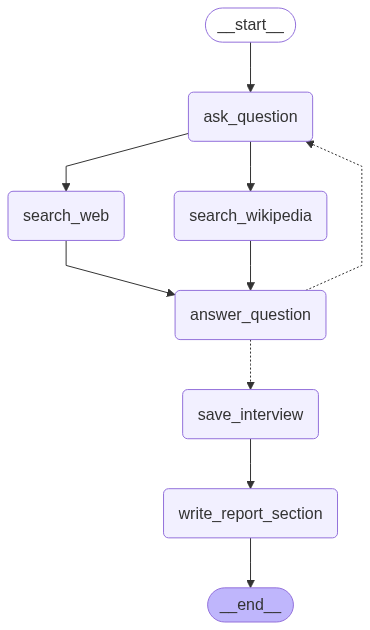

In [15]:
# Create the graph and define its data structure
interview_graph_builder = StateGraph(InterviewSession)

# Define each step (node) in the conversation flow
interview_graph_builder.add_node("ask_question", ask_question)
interview_graph_builder.add_node("search_web", search_web)
interview_graph_builder.add_node("search_wikipedia", search_wikipedia)
interview_graph_builder.add_node("answer_question", answer_question)
interview_graph_builder.add_node("save_interview", save_interview)
interview_graph_builder.add_node("write_report_section", write_report_section)

# Define the flow between steps

# Start: analyst asks a question
interview_graph_builder.add_edge(START, "ask_question")

# Then search both web and Wikipedia in parallel
interview_graph_builder.add_edge("ask_question", "search_web")
interview_graph_builder.add_edge("ask_question", "search_wikipedia")

# When both searches are done, expert answers the question
interview_graph_builder.add_edge("search_web", "answer_question")
interview_graph_builder.add_edge("search_wikipedia", "answer_question")

# Decide whether to continue or end the interview
interview_graph_builder.add_conditional_edges(
    "answer_question",
    continue_or_finish,
    ["ask_question", "save_interview"]
)

# Once done, save the full interview transcript
interview_graph_builder.add_edge("save_interview", "write_report_section")

# Finally, write the report section and finish
interview_graph_builder.add_edge("write_report_section", END)

# Create the compiled graph with memory saving
memory = MemorySaver()
interview_graph = interview_graph_builder.compile(checkpointer=memory).with_config(
    run_name="analysts_interview_experts"
)

# Display the flow as an image
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [16]:
analysts[0]

Analyst(organization='Tech Innovators Inc.', full_name='Dr. Emily Carter', job_title='MCP Research Specialist', about='Dr. Carter focuses on the theoretical implications of the Model Context Protocol, exploring how it enhances the intelligence and adaptability of AI systems by providing structured context for data interpretation.')

In [19]:
from dotenv import load_dotenv
load_dotenv()


True

In [20]:
import os
tavily_search = TavilySearchResults(
    max_results=10,
    tavily_api_key=os.getenv("TAVILY_API_KEY")
)

In [21]:
from IPython.display import Markdown

thread = {"configurable": {"thread_id": "1"}}
topic = "What Model Context Protocol is and why it makes AI smarter"

# Start the conversation with a natural topic introduction
messages = [HumanMessage(content=f"I'm researching the topic: {topic}. I'd like to ask you a few questions.")]


interview = interview_graph.invoke({
    "analyst": analysts[0],
    "messages": messages,
    "max_turns": 2
}, thread)

# Display the generated report section
Markdown(interview["report_sections"][0])

## Enhancing AI Intelligence through the Model Context Protocol

### Summary
The Model Context Protocol (MCP) emerges as a transformative framework in artificial intelligence, fundamentally enhancing AI systems' intelligence and adaptability. Introduced as an open standard by Anthropic in November 2024, the MCP standardizes how AI systems, such as large language models (LLMs), interface with external data sources and tools, creating a more integrated and responsive AI environment.

Central to the MCP is its structured context management, which addresses one of the major limitations of traditional AI systems: the inability to integrate real-time data and perform actions in the world. By enabling immediate data access and transformation, MCP allows AI systems not only to reason but also to interact dynamically with their environments. This capacity for real-time interaction is particularly beneficial in areas like "vibe coding," where a continuous flow of adaptive assistance is crucial for developers ([1](https://medium.com/@richardhightower/unlocking-ais-full-potential-understanding-the-model-context-protocol-e4fc69baeea0), [2](https://bentoml.com/llm/getting-started/tool-integration/model-context-protocol)).

Further, MCP introduces a universal interface that simplifies connections between AI systems and diverse data sources. This framework supports secure, bidirectional communication, allowing AI entities to leverage contextual metadata tagging and maintain persistent memory over interactions. Such memory capabilities significantly extend AI's conversational context, enabling systems to remember users and past discussions, which enhances user engagement and satisfaction ([2](https://www.damcogroup.com/blogs/model-context-protocol-in-ai), [1](https://en.wikipedia.org/wiki/Model_Context_Protocol)).

Adoption of MCP has been extensive, with major AI organizations like OpenAI and Google integrating the protocol into their systems. This broad acceptance showcases MCP's impact on improving interoperability across various platforms and enhancing the capabilities of AI coding assistants to produce nuanced, functional code effectively ([1](https://en.wikipedia.org/wiki/Model_Context_Protocol), [2](https://www.anthropic.com/news/model-context-protocol)). 

In summary, the Model Context Protocol represents a significant leap forward in AI contextual awareness, heralding a future where AI systems are not just intelligent but are agile participants in the digital ecosystem, equipped to navigate complex tasks with agility and precision.

### Sources
1. [Model Context Protocol - Wikipedia](https://en.wikipedia.org/wiki/Model_Context_Protocol)
2. [Unlocking AI's Full Potential: Understanding the Model Context Protocol](https://medium.com/@richardhightower/unlocking-ais-full-potential-understanding-the-model-context-protocol-e4fc69baeea0)
3. [Getting Started with Model Context Protocol - BentoML](https://bentoml.com/llm/getting-started/tool-integration/model-context-protocol)
4. [Model Context Protocol in AI - Damco Group](https://www.damcogroup.com/blogs/model-context-protocol-in-ai)
5. [Model Context Protocol - Anthropic News](https://www.anthropic.com/news/model-context-protocol)

In [22]:
print(interview["full_conversation"])

Human: I'm researching the topic: What Model Context Protocol is and why it makes AI smarter. I'd like to ask you a few questions.
AI: Hello, Dr. Emily Carter here. I appreciate your interest in the Model Context Protocol (MCP) and its effects on AI systems. To get us started, could you explain how the MCP specifically structures context for data interpretation? What are some key elements that make it distinct from other protocols, and how do those elements contribute to AI adaptability?
Human: I'm researching the topic: What Model Context Protocol is and why it makes AI smarter. I'd like to ask you a few questions.
AI: Hello! I'm Dr. Emily Carter, and I'm glad you're diving into the Model Context Protocol (MCP) and its impact on artificial intelligence. Please go ahead with your questions, and I’ll do my best to provide you with insightful and specific answers.
AI: I apologize for the confusion earlier. I'm here to help with your questions about the Model Context Protocol (MCP) and it

## Build the Final Report

In [23]:
from typing import List, Annotated
import operator
from typing_extensions import TypedDict

class ResearchProjectState(TypedDict):
    topic: str  # The main topic this project is focused on
    number_of_analysts: int  # How many analysts we want to include
    editor_feedback: str  # Notes or guidance from a human reviewer
    analysts: List[Analyst]  # The team of analysts created for this topic

    report_sections: Annotated[List[str], operator.add]  
    # Sections written by each analyst based on their interview.
    # These will be merged into a single list to build the final report.

    introduction: str  # Intro paragraph for the final report
    content: str       # Main content/body of the final report
    conclusion: str    # Final paragraph that wraps up the report
    final_report: str  # The full report (intro + content + conclusion)

### Map - Reduce

In [25]:
from langgraph.constants import Send
from langchain_core.messages import HumanMessage

def start_all_interviews(state: ResearchProjectState):
    """
    Map step of the graph:
    - If editor feedback exists, return to team-building.
    - Otherwise, launch one interview per analyst in parallel.
    """

    # If feedback is present, return to team creation
    editor_feedback = state.get("editor_feedback")
    if editor_feedback:
        return "build_team_of_analysts"

    # Otherwise, launch interviews in parallel
    return [
        Send(
            "analysts_interview_experts",
            {
                "analyst": analyst,
                "messages": [
                    HumanMessage(
                        content=f"I'm researching the topic: {state['topic']}. "
                                f"I'd like to ask you a few questions."
                    )
                ],
            },
        )
        for analyst in state["analysts"]
    ]


C:\Users\jenny\AppData\Local\Temp\ipykernel_1776\4268334060.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


### Create Writing Nodes

In [27]:
from langchain_core.messages import HumanMessage, SystemMessage

def write_report_summary(state: ResearchProjectState):
    """
    Combines all analyst memos into the main report content.
    """
    joined_sections = "\n\n".join(state["report_sections"])

    summary_instructions = f"""
You are a technical writer. Your task is to write a report on the following topic:

{state["topic"]}

Here's what you should know:

- A team of analysts interviewed experts on different subtopics.
- Each analyst wrote a short memo with their findings.

Your job:

1. You’ll receive all the memos written by the analysts.
2. Carefully review them and extract the key ideas.
3. Combine everything into one clear and cohesive summary that tells the full story.
4. Organize the insights into a single, well-written report.

Formatting instructions:

- Use Markdown.
- Don’t include any preamble or introduction to the report itself.
- Don’t use any subheadings.
- Begin with a top-level heading: ## Insights
- Do not mention the names of any analysts.
- Keep any citations from the memos (like [1], [2], etc.) exactly as they are.
- At the end, add a ## Sources section with all sources used, listed in order.
- Don’t repeat duplicate sources.

Here’s how the sources section should look:

[1] Source 1  
[2] Source 2

Here are the memos to work from:

{joined_sections}"""

    system_msg = SystemMessage(content=summary_instructions)
    user_msg = HumanMessage(content="Please summarize all the memos into a single report.")

    summary = llm.invoke([system_msg, user_msg])
    return {"content": summary.content}


def write_report_introduction(state: ResearchProjectState):
    """
    Writes the introduction section for the final report.
    """
    joined_sections = "\n\n".join(state["report_sections"])

    intro_instructions = f"""
You are a technical writer helping to finalize a report on the topic:

{state["topic"]}

You’ll receive all of the report’s main sections and will be asked to write either the introduction.

Instructions:

- Keep it clear and compelling.
- Stick to around 100 words.
- Don’t include any preamble before the section.
- Use Markdown formatting.
- Start with a strong title using a single # header
- Then add a ## Introduction heading
- Give a brief preview of the key ideas from the sections

Here are the report sections to reflect on:

{joined_sections}"""

    system_msg = SystemMessage(content=intro_instructions)
    user_msg = HumanMessage(content="Please write an introduction for the report.")

    intro = llm.invoke([system_msg, user_msg])
    return {"introduction": intro.content}


def write_report_conclusion(state: ResearchProjectState):
    """
    Writes the conclusion section for the final report.
    """
    joined_sections = "\n\n".join(state["report_sections"])

    conclusion_instructions = f"""
You are a technical writer helping to finalize a report on the topic:

{state["topic"]}

You’ll receive all of the report’s main sections and will be asked to write either the conclusion.

Instructions:

- Keep it clear and compelling.
- Stick to around 100 words.
- Don’t include any preamble before the section.
- Use Markdown formatting.
- Use a ## Conclusion heading
- Summarize the core takeaways from the report

Here are the report sections to reflect on:

{joined_sections}"""

    system_msg = SystemMessage(content=conclusion_instructions)
    user_msg = HumanMessage(content="Please write a conclusion for the report.")

    conclusion = llm.invoke([system_msg, user_msg])
    return {"conclusion": conclusion.content}


def finalize_report(state: ResearchProjectState):
    """
    Combines the intro, main content, conclusion, and sources
    into one complete Markdown-formatted report.
    """

    content = state["content"].strip()

    # Normalize Insights heading
    if content.startswith("## Insights"):
        content = content[len("## Insights"):].strip()

    # Extract sources section safely
    import re
    parts = re.split(r"\n?## Sources\n?", content, maxsplit=1)
    content = parts[0].strip()
    sources = parts[1].strip() if len(parts) > 1 else None

    # Build final report
    full_report = f"""{state["introduction"]}

---

## Insights
{content}

---

{state["conclusion"]}"""

    if sources:
        full_report += f"\n\n## Sources\n{sources}"

    return {"final_report": full_report}


### Building Everything Up

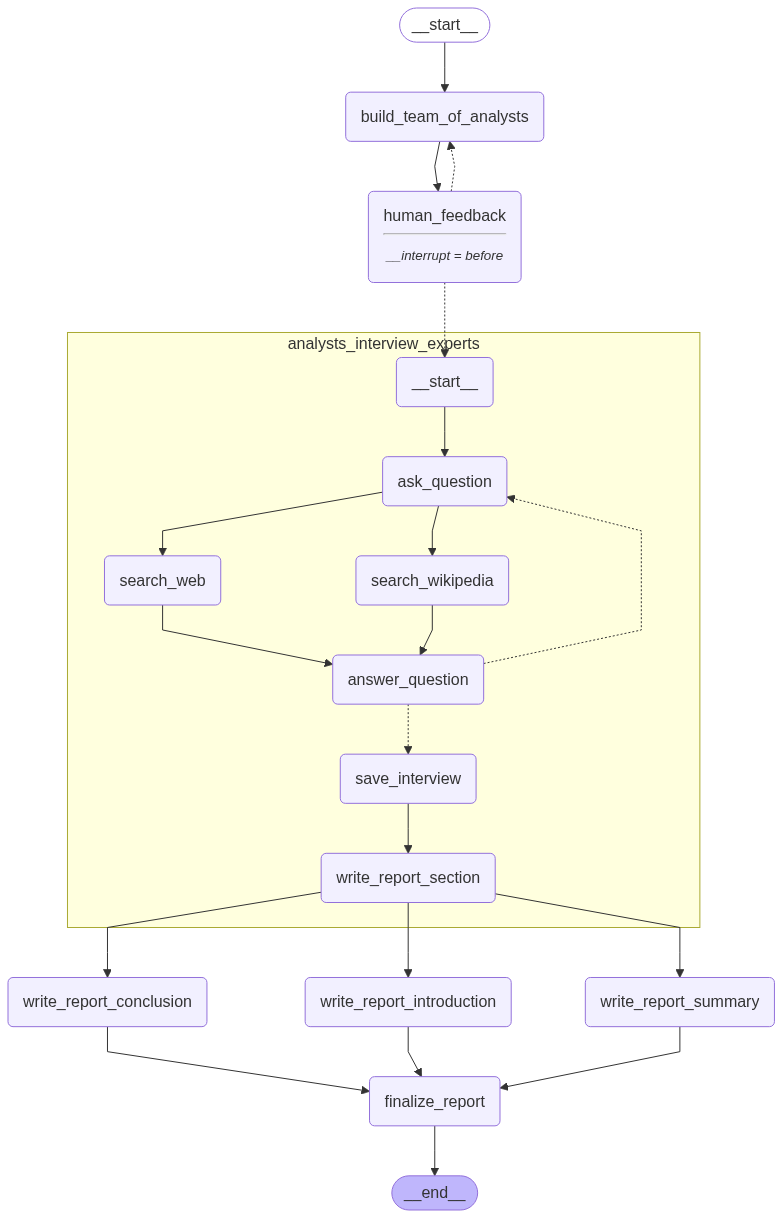

In [28]:
# Set up the full research project graph
builder = StateGraph(ResearchProjectState)

# Add all nodes
builder.add_node("build_team_of_analysts", build_team_of_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("analysts_interview_experts", interview_graph)
builder.add_node("write_report_summary", write_report_summary)
builder.add_node("write_report_introduction", write_report_introduction)
builder.add_node("write_report_conclusion", write_report_conclusion)
builder.add_node("finalize_report", finalize_report)

# Set up graph flow
builder.add_edge(START, "build_team_of_analysts")
builder.add_edge("build_team_of_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", start_all_interviews, [
    "build_team_of_analysts",
    "analysts_interview_experts"
])
builder.add_edge("analysts_interview_experts", "write_report_summary")
builder.add_edge("analysts_interview_experts", "write_report_introduction")
builder.add_edge("analysts_interview_experts", "write_report_conclusion")
builder.add_edge(
    ["write_report_summary", "write_report_introduction", "write_report_conclusion"],
    "finalize_report"
)
builder.add_edge("finalize_report", END)

# Compile the graph
memory = MemorySaver()
research_graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# Display the full graph
display(Image(research_graph.get_graph(xray=1).draw_mermaid_png()))

### Testing

In [29]:
# Inputs
thread = {"configurable": {"thread_id": 1}}
number_of_analysts = 3 
topic = "What Model Context Protocol is and why it makes AI smarter"


# Run the graph until the first interruption
for event in research_graph.stream({"topic": topic,
                           "number_of_analysts": number_of_analysts}, 
                          thread, 
                          stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(analyst.profile)


Name: Dr. Sarah Consiglio
Title: Lead AI Ethicist
Organization: AI Research Institute
About: Dr. Consiglio focuses on ensuring that the deployment of the Model Context Protocol aligns with ethical standards. She advocates for responsible AI usage to prevent bias and promote transparency.
        

Name: Mr. Raj Patel
Title: Senior Data Scientist
Organization: Tech Innovations Lab
About: Mr. Patel specializes in data integration and context modeling. He is keen on exploring how the Model Context Protocol can enhance machine learning algorithms by improving data relevance and contextuality.
        

Name: Ms. Lisa Chen
Title: AI Policy Analyst
Organization: Global AI Consortium
About: Ms. Chen is dedicated to understanding the implications of AI advancements on society. She is examining the socio-economic effects of the Model Context Protocol to guide policy development and regulatory frameworks.
        


In [30]:
state = research_graph.get_state(thread)
state.next

('human_feedback',)

In [31]:
# We now update the state as if we are the human_feedback node
research_graph.update_state(thread, {
    "editor_feedback": "I think it would be helpful to add an analyst who focuses on how developers actually use MCP in real-world coding."
    }, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07af20-8fb5-6a71-8002-23da7a7b1ad8'}}

In [32]:
# Check
for event in research_graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(analyst.profile)


Name: Dr. Sarah Consiglio
Title: Lead AI Ethicist
Organization: AI Research Institute
About: Dr. Consiglio focuses on ensuring that the deployment of the Model Context Protocol aligns with ethical standards. She advocates for responsible AI usage to prevent bias and promote transparency.
        

Name: Mr. Raj Patel
Title: Senior Data Scientist
Organization: Tech Innovations Lab
About: Mr. Patel specializes in data integration and context modeling. He is keen on exploring how the Model Context Protocol can enhance machine learning algorithms by improving data relevance and contextuality.
        

Name: Ms. Lisa Chen
Title: AI Policy Analyst
Organization: Global AI Consortium
About: Ms. Chen is dedicated to understanding the implications of AI advancements on society. She is examining the socio-economic effects of the Model Context Protocol to guide policy development and regulatory frameworks.
        

Name: Dr. Sarah Thompson
Title: AI Research Scientist
Organization: Tech Innovat

In [33]:
# Confirm we are happy
research_graph.update_state(thread, {"editor_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07af20-b043-6219-8004-fe947c1d36fc'}}

In [34]:
# Continue
for event in research_graph.stream(None, thread, stream_mode="updates"):
    node_name = next(iter(event.keys()))
    print("> " + node_name)

> analysts_interview_experts
> analysts_interview_experts
> analysts_interview_experts
> write_report_introduction
> write_report_conclusion
> write_report_summary
> finalize_report


In [35]:
from IPython.display import Markdown
final_state = research_graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# What Model Context Protocol is and Why It Makes AI Smarter

## Introduction

The Model Context Protocol (MCP) is a groundbreaking innovation designed to elevate the intelligence of artificial intelligence (AI) systems, particularly large language models (LLMs). By enabling seamless integration and communication of contextual information between AI applications and external data sources, MCP enhances capabilities such as context awareness, adaptability, and interoperability. This report delves into how MCP revolutionizes AI performance, improves decision-making, and fosters a personalized user experience. Key areas of exploration include the protocol's ability to maintain context across interactions, the adoption of adaptive learning, and its transformative impact on various industries. Together, these facets illustrate how MCP is making AI smarter and more effective.

---

## Insights
The Model Context Protocol (MCP) is a groundbreaking open standard introduced by Anthropic in November 2024 that significantly enhances the intelligence and performance of artificial intelligence (AI) systems, especially large language models (LLMs). It provides a standardized framework for how applications communicate contextual information to these models, which facilitates more dynamic interactions with external tools and data sources.

MCP enables secure, bidirectional connections that allow AI systems to access real-time data, overcoming the limitations posed by traditional AI models that often operated in isolated environments. This capability ensures that AI can maintain persistent context across multiple interactions, thus improving its memory and adaptive learning abilities. For example, AI-powered virtual assistants can now utilize MCP to access real-time customer profiles and prior interactions, allowing personalized and efficient responses in customer support scenarios [1][2][3][4].

Key features of MCP include effective data ingestion and transformation, allowing AI to manipulate and access diverse data sources; contextual metadata tagging that enhances the prioritization of information based on user queries; interoperability among different AI platforms; and support for rich interactive experiences through secure communications. These elements work in concert to facilitate seamless integrations and improve user engagement across various applications, including customer service, legal research, and coding environments [1][2][3][4][5].

In software development, tools utilizing MCP can provide context-aware assistance adapted to ongoing interactions, significantly transforming the user experience and efficiency in coding tasks. For example, the integration of MCP within tools like Codeium, Zed, and Replit allows developers to work with real-time project contexts, thus streamlining their workflows and reducing the need for repetitive inputs [4][6].

Moreover, MCP enables multi-agent collaboration, where AI systems can share relevant context about ongoing tasks, such as supply chain statuses or market conditions, which further enhances decision-making processes. This shift from reactive to proactive AI interactions fosters smarter, more context-aware applications, ultimately leading to improved outcomes across various industries [1][2][3][4][5].

MCP positions itself as a bridge between AI models and real-world data, marking a pivotal development in making AI smarter and more efficient by promoting deeper interactions with data and enabling intelligent collaborative approaches.

---

## Conclusion

The Model Context Protocol (MCP) marks a significant advancement in artificial intelligence, empowering AI systems to operate with enhanced context awareness and integration capabilities. By standardizing communication and facilitating real-time data access, MCP transforms AI interactions from reactive to proactive, fostering personalized and efficient user experiences. With features like persistent memory, contextual metadata tagging, and secure connections, MCP enables smarter decision-making across various applications, from customer support to software development. As this protocol continues to be adopted, it promises to redefine how AI systems function, ultimately leading to a more intelligent and effective technological ecosystem.

## Sources
[1] https://modelcontextprotocol.io/  
[2] https://www.moveworks.com/us/en/resources/blog/model-context-protocol-mcp-explained  
[3] https://www.ibm.com/think/topics/model-context-protocol  
[4] https://medium.com/@zbabar/the-model-context-protocol-explained-5f35223e4d56  
[5] https://www.anthropic.com/news/model-context-protocol  
[6] https://odsc.medium.com/5-key-benefits-of-using-model-context-protocol-in-ai-systems-c030c8f5061a